# Library Import

In [1]:
#to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import scipy
import struct

from pathlib import Path
from sympy import divisors

from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

from scipy.stats import bootstrap

from scipy.optimize import curve_fit #for the fit

# Input Reading

## reading

In [3]:
#dirName = '../mesons-master/build/dat/'
#name = 'odd_prova26.odd_df2_4fop'
dirName = '../../data_from_scp/'
#name = 'tm_mesons_run11.mesons'
#name = 'tm_mesons_run12.mesons'
#name = 'tm_mesons_run13.mesons'
#name = 'tm_mesons_run14.mesons'
#name = 'tm_mesons_run15.mesons'
#name = 'tm_mesons_run16.mesons'
name = 'tm_mesons_run17.mesons'
datName = name + '.dat'

fileName = dirName + datName

In [4]:
plot_base_dir = 'plots/'
plot_dir = 'plot_'+name.split('.')[0]
Path(plot_base_dir+plot_dir).mkdir(parents=True, exist_ok=True)

In [5]:
verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 0 #number of configurations (counting from the end) not read

In [6]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 4 integers, 4x4=16byte
    header_size= 4*4

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type = struct.unpack("iiii", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    
    mu1=['']*ncorr
    mu2=['']*ncorr

    type1=['']*ncorr
    type2=['']*ncorr
    
    x0=['']*ncorr
    isreal=['']*ncorr

    
    #each correlator has an header of size given by 4x8 + 4x4 = 48byte
    corr_header_size = 4*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], mu1[i], mu2[i], type1[i], type2[i], x0[i], isreal[i] = struct.unpack("ddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex) #correlators
    

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          sizeof(int) (=confNumber)           ncorr * nnoise * tvals * 2 (re+im) * 8 (sizeof(double))
    conf_len = 4                                 +  nnoise * tvals * (2*ncorr - np.sum(isreal))         * 8         
    #the term with isreal is there because for real correlators only the real part gets stored

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        corr.fill(complex(0,0))

        #initialize start reading
        start_reading = start_conf + 4

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):
            
            #reading of 2 point functions
            for t in range(tvals):
                
                for inoise in range(nnoise):

                    if isreal[ic]==0:
                        #read re and im
                        re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                        #store them
                        corr[ic][t][inoise] = complex(re,im)
                        #update start reading
                        start_reading = start_reading+16

                    if isreal[ic]==1:
                        #read re
                        re = struct.unpack("d",fileContent[start_reading:start_reading+8])[0]
                        #store it
                        corr[ic][t][inoise] = complex(re,0.0)
                        #update start reading
                        start_reading = start_reading+8
                        
                    

        #store of correlators associated to the given configuration
        conf_dict[str(conf_number)] = corr.copy()

Reading: Gauge Conf = 1

Reading: Gauge Conf = 2

Reading: Gauge Conf = 3

Reading: Gauge Conf = 4

Reading: Gauge Conf = 5

Reading: Gauge Conf = 6

Reading: Gauge Conf = 7

Reading: Gauge Conf = 8

Reading: Gauge Conf = 9

Reading: Gauge Conf = 10

Reading: Gauge Conf = 11

Reading: Gauge Conf = 12

Reading: Gauge Conf = 13

Reading: Gauge Conf = 14

Reading: Gauge Conf = 15

Reading: Gauge Conf = 16

Reading: Gauge Conf = 17

Reading: Gauge Conf = 18

Reading: Gauge Conf = 19

Reading: Gauge Conf = 20

Reading: Gauge Conf = 21

Reading: Gauge Conf = 22

Reading: Gauge Conf = 23

Reading: Gauge Conf = 24

Reading: Gauge Conf = 25

Reading: Gauge Conf = 26

Reading: Gauge Conf = 27

Reading: Gauge Conf = 28

Reading: Gauge Conf = 29

Reading: Gauge Conf = 30

Reading: Gauge Conf = 31

Reading: Gauge Conf = 32

Reading: Gauge Conf = 33

Reading: Gauge Conf = 34

Reading: Gauge Conf = 35

Reading: Gauge Conf = 36

Reading: Gauge Conf = 37

Reading: Gauge Conf = 38

Reading: Gauge Conf =

In [7]:
#check on correct lenght calculations
(len(fileContent)-header_size-corr_header_size*ncorr)/conf_len

np.float64(100.0)

In [8]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)
nconf

100

In [9]:
#creation of a numpy array with all the correlators
correlators = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    correlators[iconf] = conf_dict[nameconf]

In [10]:
if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(correlators))

(nconf, ncorrelators, tvals, nnoise)
(100, 14, 32, 100)


In [11]:
if verbose:
    for icorr in range(ncorr):
        print(f"k1  = {k1[icorr]}\n")
        print(f"k2  = {k2[icorr]}\n")
        print(f"mu1 = {mu1[icorr]}\n")
        print(f"mu2 = {mu2[icorr]}\n")
        print(f"G1  = {type1[icorr]}\n")
        print(f"G2  = {type2[icorr]}\n")
        print(f"x0  = {x0[icorr]}\n")
        print(f"isr = {isreal[icorr]}\n\n")

k1  = 0.135217

k2  = 0.135217

mu1 = 0.0113

mu2 = 0.0113

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0113

mu2 = -0.0113

G1  = 5

G2  = 5

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0151

mu2 = 0.0151

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0151

mu2 = -0.0151

G1  = 5

G2  = 5

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0302

mu2 = 0.0302

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0302

mu2 = -0.0302

G1  = 5

G2  = 5

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = 0.0454

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = -0.0454

G1  = 5

G2  = 5

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0605

mu2 = 0.0605

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0605

mu2 = -0.0605

G1  = 5

G2  = 5

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.1

In [12]:
#true_masses = np.asarray([0.2150,0.2449,0.3401,0.4182,0.4873])
true_masses = np.asarray([0.2150,0.2449,0.3401,0.4182,0.4873,0.5512,0.1811])
mus = np.array(mu1[::2])

## cast to real

In [13]:
correlators = correlators.real
#correlators = np.abs(correlators)

## average over noise

In [14]:
corr_navg = correlators.mean(axis=-1)
if verbose:
    print("(nconf, ncorrelators, tvals)")
    print(np.shape(corr_navg))

(nconf, ncorrelators, tvals)
(100, 14, 32)


## preliminary plots

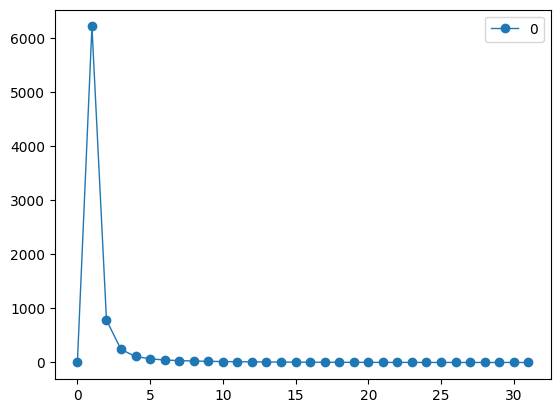

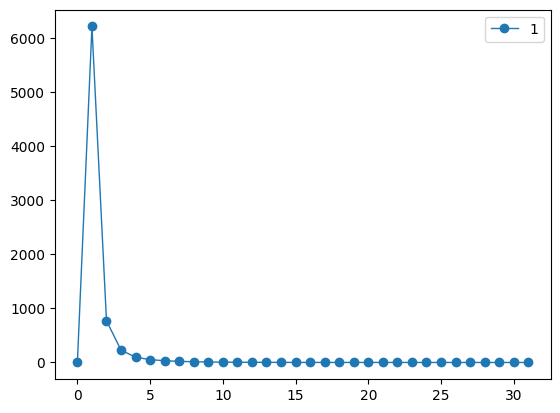

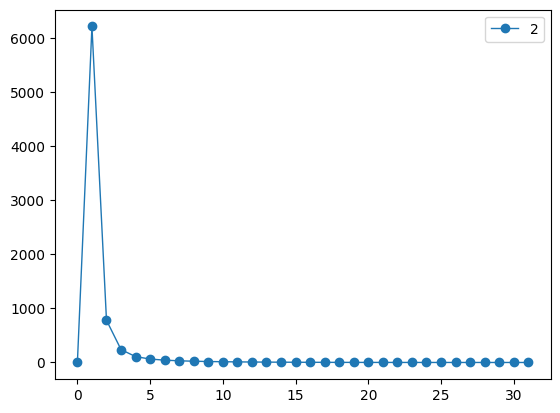

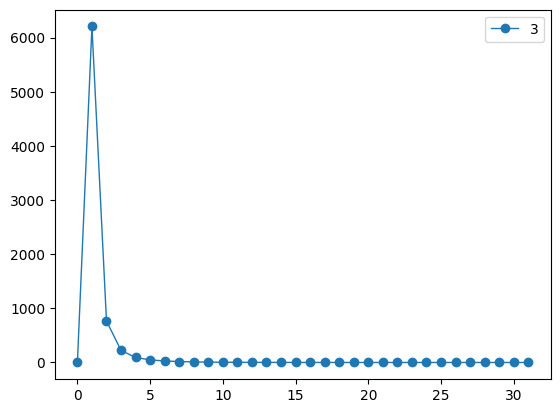

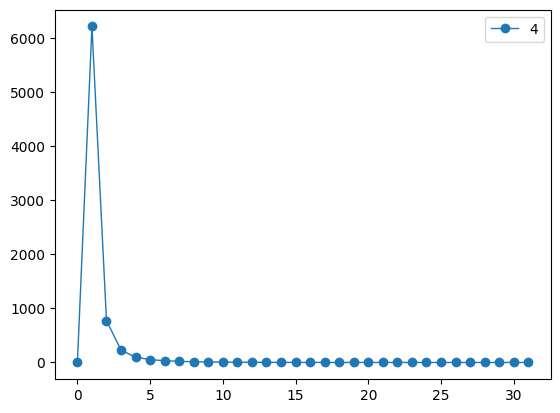

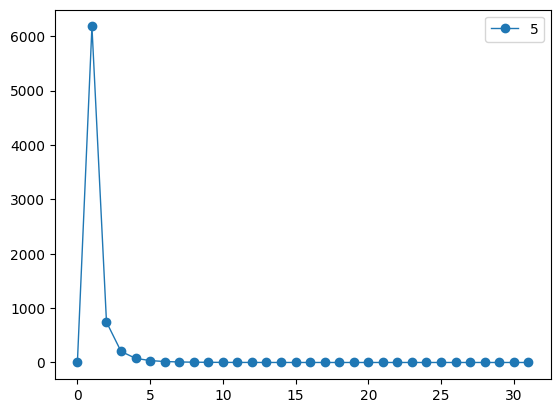

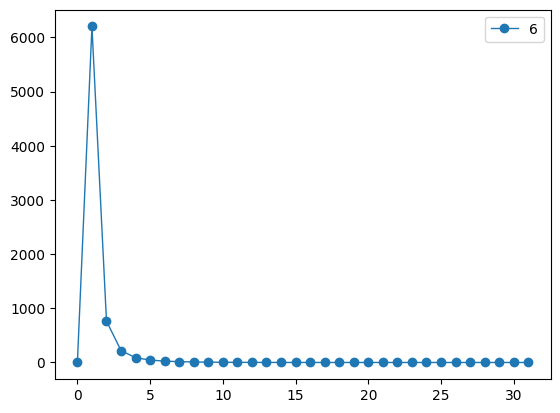

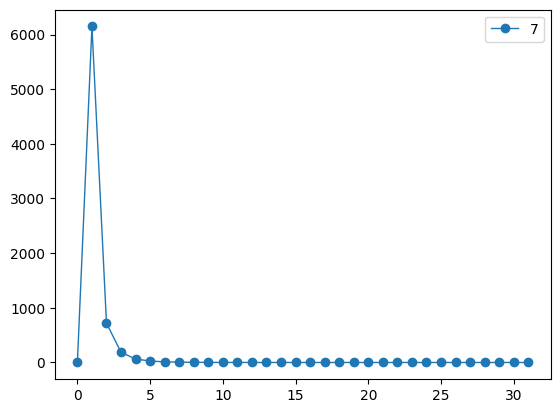

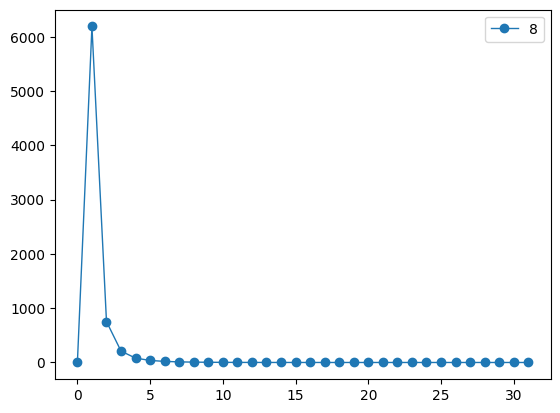

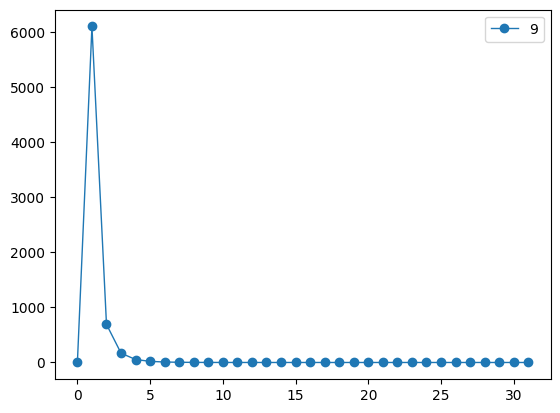

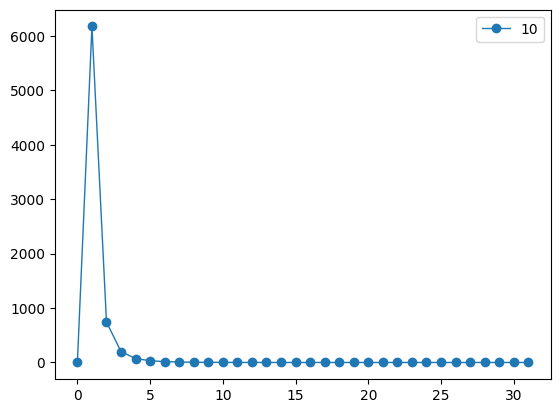

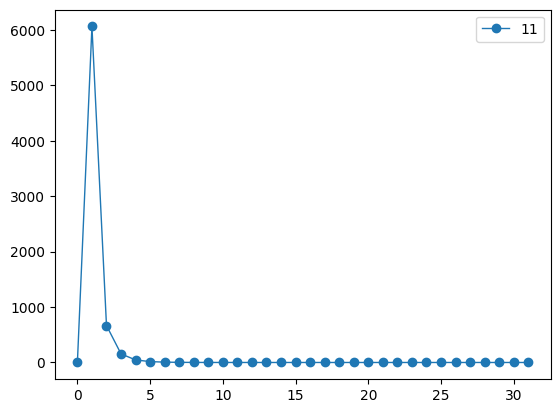

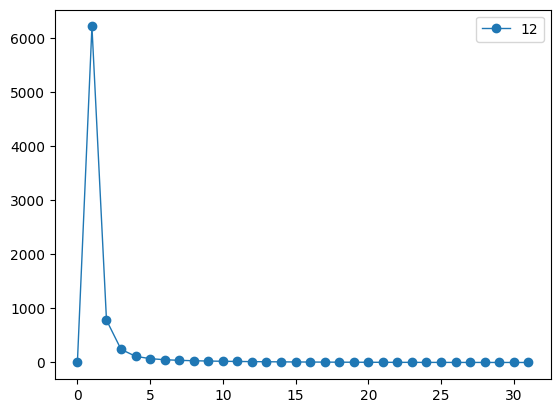

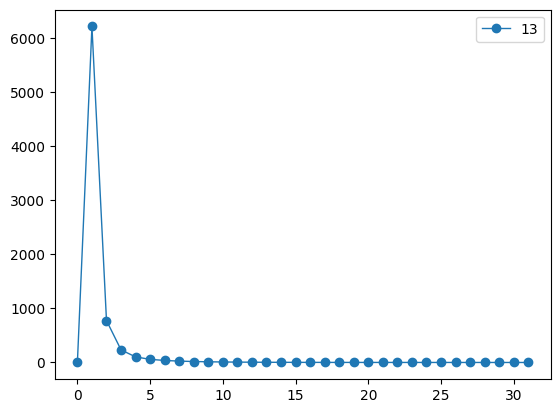

In [15]:
times = np.arange(tvals)

for ic in range(ncorr):
    _=plt.figure()
    _=plt.plot(times,np.mean(corr_navg[:,ic,:],axis=0), '-o',linewidth = 1,label=str(ic))
    _=plt.legend()

# Jacknife with effective and fit mass

In [16]:
def chi2(result,data,data_std):
    return np.sum( ((result-data)/data_std)**2 )/len(data_std)
    
def fit_sinh_x(t,amp,mass):
    T=tvals-1
    return amp*np.sinh(mass*(T-t)) #tvals-1 because T=tvals-1

def mass(corr_ratio,t,max_it=150,verb=False):

    eps=3e-7

    Time = tvals-1

    m0 = np.log(corr_ratio)

    massa = m0 #at iteration 0 the sinh is an exp and the mass is simply the log of the ration of correlators

    if corr_ratio <1.0:
        massa = 0
        return massa

    for it in range(max_it):


        '''
        if tvals-2*(t-1) -2 == 0 or tvals-2*(t-1) +2 ==0:
           break
        '''        
        

        #computes new mass from previous one
        
        #new_m = np.log(corr_ratio * (1-np.exp(-2*old_m*(tvals-t-1)))/(1-np.exp(-2*old_m*(tvals-t)) ) )

        den = 1 - np.exp( -2*massa * ( Time-t  ) )
        num = 1 - np.exp( -2*massa * ( Time-t-1) )
        

        new_massa = np.log( corr_ratio * num/den )

        if it%5 == 0 and verb==True:
            print(f"x t{t} it{it} delta = {np.abs((new_massa-massa)/massa)} \n")
        
        '''
        if np.abs(new_massa)>4.0 or new_massa<0:
            massa = 10
            break
        '''

        
        if np.abs(massa-new_massa)/massa < eps:
            massa=new_massa
            break
        

        massa = new_massa

    return massa

## Average over Noise

In [17]:
#it is already done above
if verbose:
    print("(nconf,ncorr,tvals)")
    print(np.shape(corr_navg))

(nconf,ncorr,tvals)
(100, 14, 32)


## Creation of jackknife Replicates

In [18]:
delta = 1 #binning of the jackknife procedure (we delete delta conf for each replicate

corr_navg_resamp = np.asarray( [np.delete(corr_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0) for iconf in range(0,nconf,delta)] )

nresamples = int(nconf/delta)


if verbose:
    print("(nresamples,nconf-delta,ncorr,tvals)")
    print(np.shape(corr_navg_resamp))

(nresamples,nconf-delta,ncorr,tvals)
(100, 99, 14, 32)


## Correlator Identification

In [19]:
#first we take the correlator averaged over the gauge configurations (for each subsample)
corr_navg_resamp_gavg = corr_navg_resamp.mean(axis=1)

#this is the array with the replicates !!!
eff_mass_array = np.empty(shape=(ncorr,nresamples,tvals-1),dtype=float)
fit_mass_array = np.empty(shape=(ncorr,nresamples),dtype=float)
fit_amp_array = np.empty(shape=(ncorr,nresamples),dtype=float)

#chi2_array = np.empty(shape=(ncorr,nresamples),dtype=float)

chosen_maxit = 2000

#then we estimate the mass
for icorr in range(ncorr):


    #preparation for fit
    guess_mass=true_masses[int(icorr/2)]
    cut=8
    fit_times=times[cut:-cut]
    

    
    for ires in range(nresamples):
        
        for t in range(tvals-1):
            #insert here the formula for the mass:
            eff_mass_array[icorr,ires,t] = mass( corr_navg_resamp_gavg[ires,icorr,t] /  corr_navg_resamp_gavg[ires,icorr,t+1] , t,max_it=chosen_maxit)

        
        #mass from fit for each of the replicate
        guess_amp=corr_navg_resamp_gavg[ires,icorr,int(tvals/2)] / np.sinh( (tvals-1-tvals/2) * guess_mass )
        guess=[guess_amp,guess_mass]
        fit_data=corr_navg_resamp_gavg[ires,icorr,cut:-cut]
        popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess,maxfev = 1300)
        perr_x = np.sqrt(np.diag(pcov_x))
        fit_mass_array[icorr,ires] = popt_x[1]
        fit_amp_array[icorr,ires] = popt_x[0]



#we then estimate the mass also on the whole dataset
corr_navg_gavg = corr_navg.mean(axis=0)

#this is the array with the mass computed on the whole dataset !!!
eff_mass_array_jacktotal = np.empty(shape=(ncorr,tvals-1),dtype=float)
fit_mass_array_jacktotal = np.empty(shape=(ncorr),dtype=float)
fit_amp_array_jacktotal = np.empty(shape=(ncorr),dtype=float)


for icorr in range(ncorr):

    #preparation for fit
    guess_mass=true_masses[int(icorr/2)]
    cut=8
    fit_times=times[cut:-cut]

    
    for t in range(tvals-1):
        eff_mass_array_jacktotal[icorr,t] = mass( corr_navg_gavg[icorr,t] / corr_navg_gavg[icorr,t+1] , t, verb=False, max_it=chosen_maxit)
        

    #mass from fit for each of the replicate
    guess_amp=corr_navg_gavg[icorr,int(tvals/2)] / np.sinh( (tvals-1-tvals/2) * guess_mass )
    guess=[guess_amp,guess_mass]
    fit_data=corr_navg_gavg[icorr,cut:-cut]
    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess,maxfev = 1200)
    perr_x = np.sqrt(np.diag(pcov_x))
    fit_mass_array_jacktotal[icorr] = popt_x[1]
    fit_amp_array_jacktotal[icorr] = popt_x[0]




if verbose:
    print("(nresamples,ncorr,tvals)")
    print(np.shape(corr_navg_resamp_gavg))
    
    print("(ncorr,tvals)")
    print(np.shape(corr_navg_gavg))

/tmp/ipykernel_25746/1858215969.py:14: RuntimeWarning: divide by zero encountered in log
  m0 = np.log(corr_ratio)
/tmp/ipykernel_25746/3013304493.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  eff_mass_array[icorr,ires,t] = mass( corr_navg_resamp_gavg[ires,icorr,t] /  corr_navg_resamp_gavg[ires,icorr,t+1] , t,max_it=chosen_maxit)
/tmp/ipykernel_25746/1858215969.py:36: RuntimeWarning: invalid value encountered in scalar multiply
  num = 1 - np.exp( -2*massa * ( Time-t-1) )


(nresamples,ncorr,tvals)
(100, 14, 32)
(ncorr,tvals)
(14, 32)


/tmp/ipykernel_25746/3013304493.py:60: RuntimeWarning: divide by zero encountered in scalar divide
  eff_mass_array_jacktotal[icorr,t] = mass( corr_navg_gavg[icorr,t] / corr_navg_gavg[icorr,t+1] , t, verb=False, max_it=chosen_maxit)


In [20]:
#the estimate is the mean of the replicates
eff_estimate = np.mean(eff_mass_array,axis=1) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
eff_bias = (nresamples-1) * (eff_estimate-eff_mass_array_jacktotal)
#the std is given by the following formula (variance of replicates times n-1)
eff_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (eff_mass_array[icorr] - eff_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
eff_estimate_biascorr = eff_estimate-eff_bias

if verbose:
    print("(ncorr,tvals)")
    print(np.shape(eff_estimate_biascorr))
    print(np.shape(eff_std))


#the estimate is the mean of the replicates
fit_estimate = np.mean(fit_mass_array,axis=1) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
fit_bias = (nresamples-1) * (fit_estimate-fit_mass_array_jacktotal)
#the std is given by the following formula (variance of replicates times n-1)
fit_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (fit_mass_array[icorr] - fit_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
fit_estimate_biascorr = fit_estimate-fit_bias

if verbose:
    print("(ncorr)")
    print(np.shape(fit_estimate_biascorr))
    print(np.shape(fit_std))


#the estimate is the mean of the replicates
amp_fit_estimate = np.mean(fit_amp_array,axis=1) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
amp_fit_bias = (nresamples-1) * (amp_fit_estimate-fit_amp_array_jacktotal)
#the std is given by the following formula (variance of replicates times n-1)
amp_fit_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (fit_amp_array[icorr] - amp_fit_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
amp_fit_estimate_biascorr = amp_fit_estimate-amp_fit_bias

if verbose:
    print("(ncorr)")
    print(np.shape(fit_estimate_biascorr))
    print(np.shape(fit_std))

(ncorr,tvals)
(14, 31)
(14, 31)
(ncorr)
(14,)
(14,)
(ncorr)
(14,)
(14,)


In [21]:
M_fit = fit_estimate_biascorr
M_fit_std = fit_std

amp_fit = amp_fit_estimate_biascorr
amp_fit_std = amp_fit_std

In [22]:
cut = 8

#left_cut=16
#right_cut=8
left_cut=cut
right_cut=cut+5

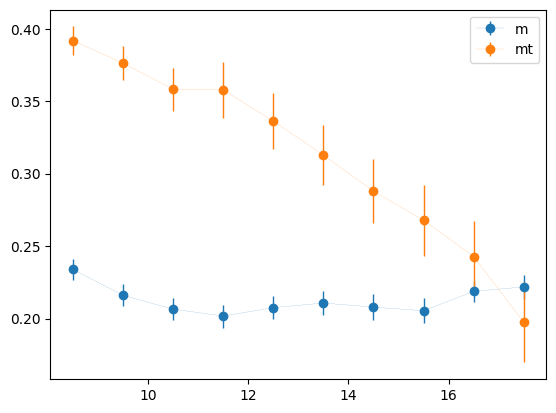

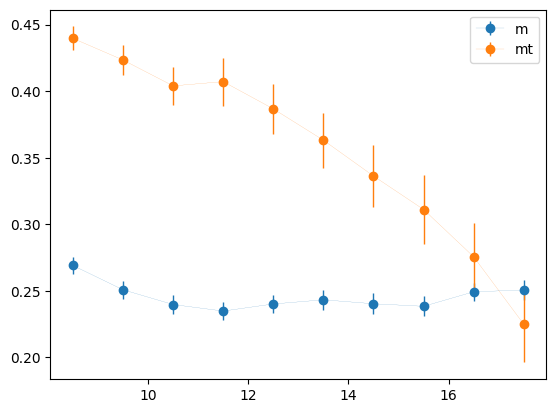

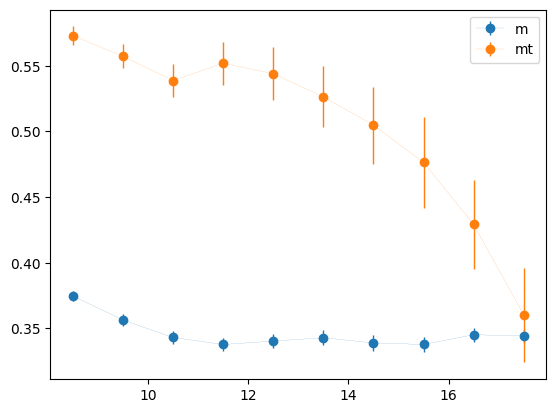

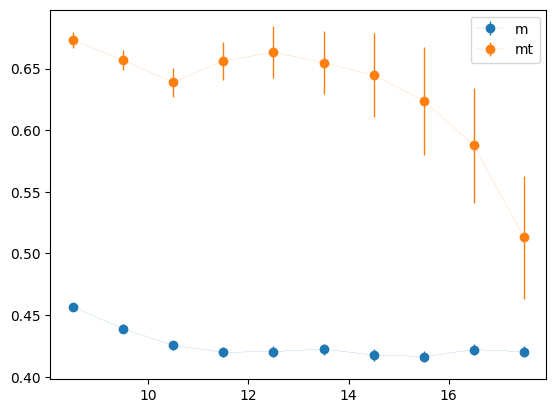

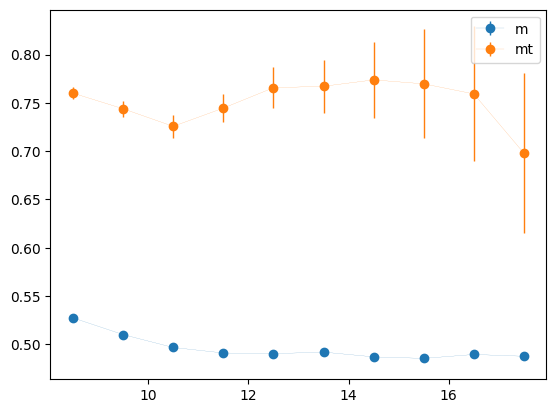

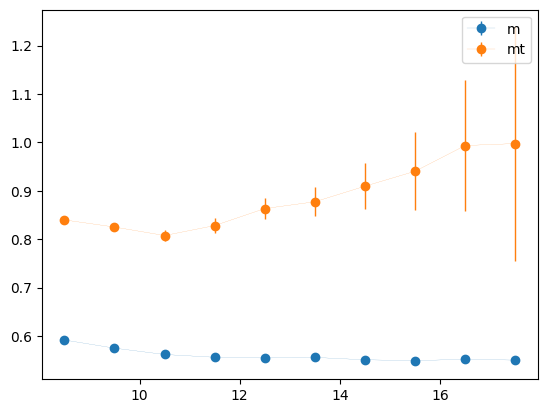

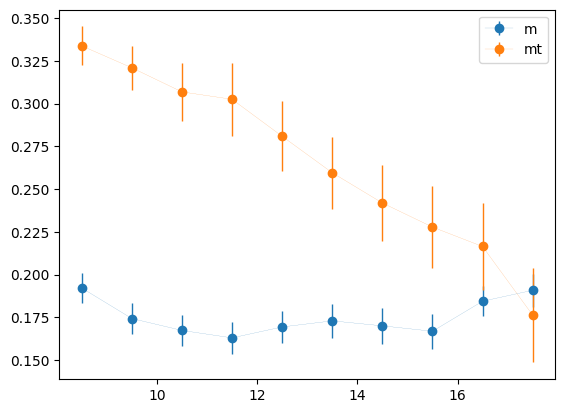

In [23]:
#check on correctness of plateau
#eff_estimate_biascorr[1::2,cut:-cut]

mass_times = times[left_cut:-right_cut-1]+0.5

for icorr in range(0,ncorr,2):
    _=plt.figure()
    _=plt.errorbar(mass_times,eff_estimate_biascorr[icorr,left_cut:-right_cut],yerr=eff_std[icorr,left_cut:-right_cut],marker='o',linewidth=0.1,elinewidth=1.0,label='m')
    _=plt.errorbar(mass_times,eff_estimate_biascorr[icorr+1,left_cut:-right_cut],yerr=eff_std[icorr+1,left_cut:-right_cut],marker='o',linewidth=0.1,elinewidth=1.0,label='mt')
    _=plt.legend()

In [24]:
sqM_fit = fit_estimate_biascorr**2
sqM_fit_std = 2*np.abs(fit_estimate_biascorr)*fit_std

M_eff = np.empty(shape=(ncorr),dtype=float)
M_eff_std = np.empty(shape=(ncorr),dtype=float)
chosen_cuts = np.empty(shape=(ncorr),dtype=int)

#plateau determination for each correlator
for icorr in range(ncorr):

    chosen_cut = int(tvals/2)-1
    
    for icut in range(3,int(tvals/2)):
        imeff = np.mean(eff_estimate_biascorr[icorr,icut:-icut])
        if chi2(imeff,eff_estimate_biascorr[icorr,icut:-icut],eff_std[icorr,icut:-icut])  < 1:
            chosen_cut = icut
            chosen_cuts[icorr]=chosen_cut
            print(f"icorr{icorr}  cut{chosen_cut}")
            break
    
    M_eff[icorr] = np.mean(eff_estimate_biascorr[icorr,chosen_cut:-chosen_cut])
    M_eff_std[icorr] = np.sqrt( np.mean( eff_std[icorr,chosen_cut:-chosen_cut]**2 ) )

#M_eff = np.mean(eff_estimate_biascorr[:,left_cut:-right_cut],axis=1)
#M_eff_std = np.sqrt( np.mean( eff_std[:,left_cut:-right_cut]**2 ,axis=1 ) )
sqM_eff = M_eff**2
sqM_eff_std = 2*np.abs(M_eff)*M_eff_std

sqM_true = true_masses**2

icorr0  cut9
icorr1  cut14
icorr2  cut9
icorr3  cut15
icorr4  cut9
icorr5  cut14
icorr6  cut10
icorr7  cut14
icorr8  cut10
icorr9  cut12
icorr10  cut11
icorr11  cut11
icorr12  cut12
icorr13  cut14


/tmp/ipykernel_25746/1858215969.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum( ((result-data)/data_std)**2 )/len(data_std)


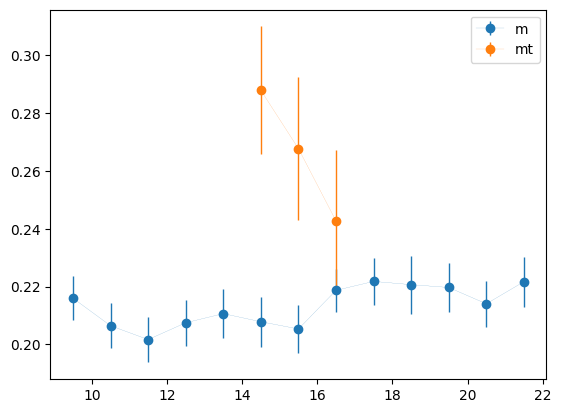

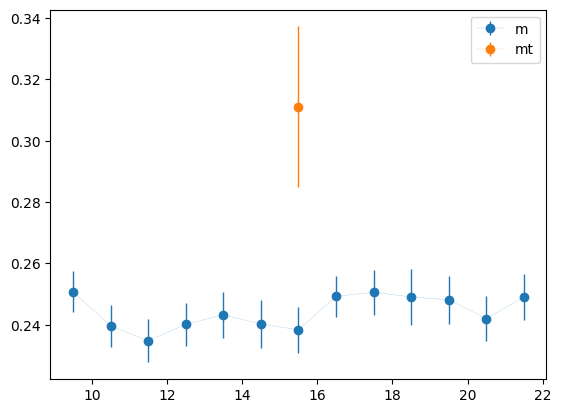

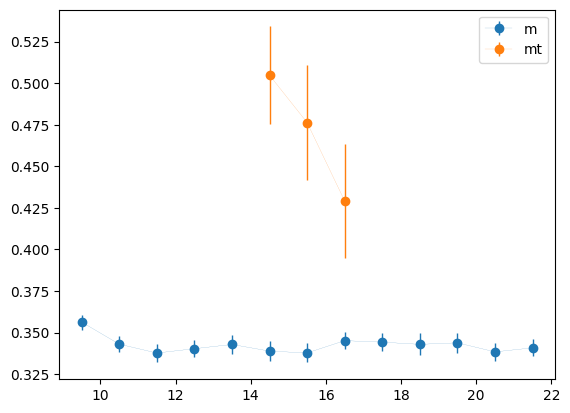

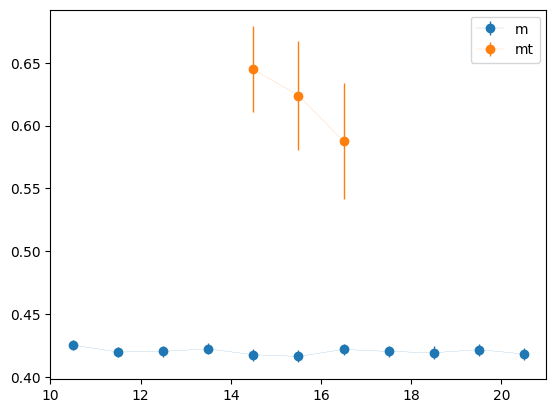

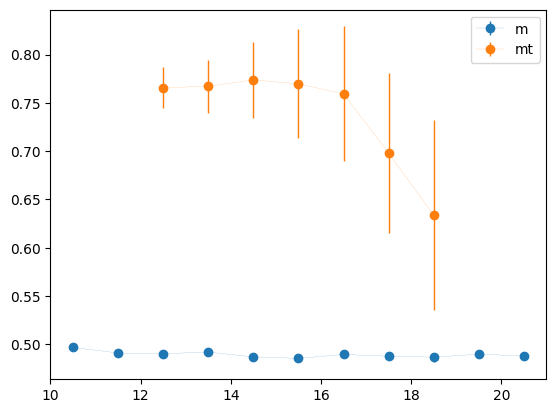

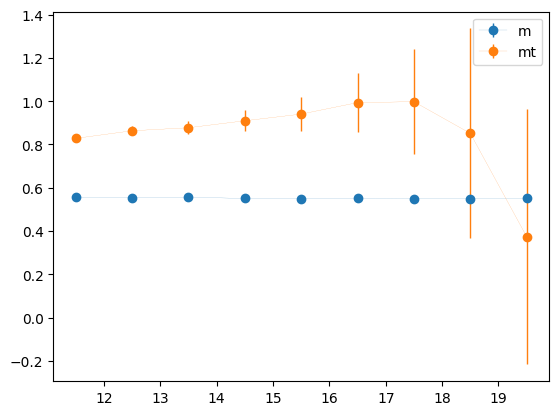

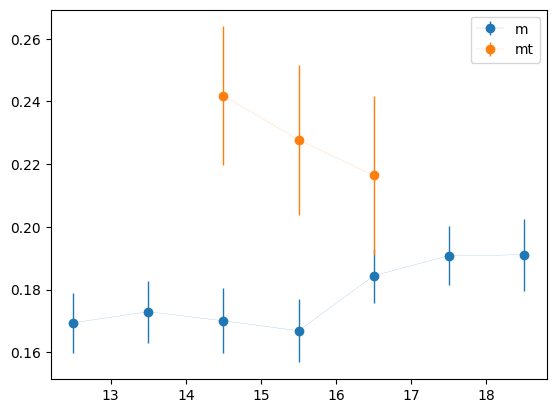

In [25]:

for icorr in range(0,ncorr,2):
    _=plt.figure()
    cut_m=chosen_cuts[icorr]
    mass_times = times[cut_m:-cut_m-1]+0.5
    _=plt.errorbar(mass_times,eff_estimate_biascorr[icorr,cut_m:-cut_m],yerr=eff_std[icorr,cut_m:-cut_m],marker='o',linewidth=0.1,elinewidth=1.0,label='m')
    cut_mt=chosen_cuts[icorr+1]
    mass_times = times[cut_mt:-cut_mt-1]+0.5
    _=plt.errorbar(mass_times,eff_estimate_biascorr[icorr+1,cut_mt:-cut_mt],yerr=eff_std[icorr+1,cut_mt:-cut_mt],marker='o',linewidth=0.1,elinewidth=1.0,label='mt')
    _=plt.legend()

In [26]:
#M-Mtilda division

M2_fit = sqM_fit[::2]
M2_fit_std = sqM_fit_std[::2]

M2t_fit = sqM_fit[1::2]
M2t_fit_std = sqM_fit_std[1::2]


M2_eff = sqM_eff[::2]
M2_eff_std = sqM_eff_std[::2]

M2t_eff = sqM_eff[1::2]
M2t_eff_std = sqM_eff_std[1::2]

In [27]:
def fit_lin(x,m,q):
    return m * x + q

mu_range = np.linspace(0,np.max(mu1)*1.1,100)

guess_par = [ ( M2_fit[-1]-M2_fit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2_fit, sigma= M2_fit_std, p0=guess_par)
M2_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2 fit")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( M2t_fit[-1]-M2t_fit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2t_fit, sigma= M2t_fit_std, p0=guess_par)
M2t_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2t fit")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( M2_eff[-1]-M2_eff[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2_eff, sigma= M2_eff_std, p0=guess_par)
M2_eff_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2 eff")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( M2t_eff[-1]-M2t_eff[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2t_eff, sigma= M2t_eff_std, p0=guess_par)
M2t_eff_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2t eff")
print(popt)
print(np.sqrt(np.diag(pcov)))


guess_par = [ ( sqM_true[-1]-sqM_true[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, sqM_true, p0=guess_par)
fit_reference = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2 true")
print(popt)
print(np.sqrt(np.diag(pcov)))


M2 fit
[ 4.45188994 -0.00582875]
[0.04975821 0.0018522 ]

M2t fit
[8.86908311 0.03236756]
[0.1480271 0.0058607]

M2 eff
[ 3.99259147e+00 -7.44320612e-04]
[0.04509401 0.00186857]

M2t eff
[ 8.37033151 -0.01915496]
[0.54259388 0.00799122]

M2 true
[ 3.95565539e+00 -1.52047020e-04]
[0.05914152 0.00252526]


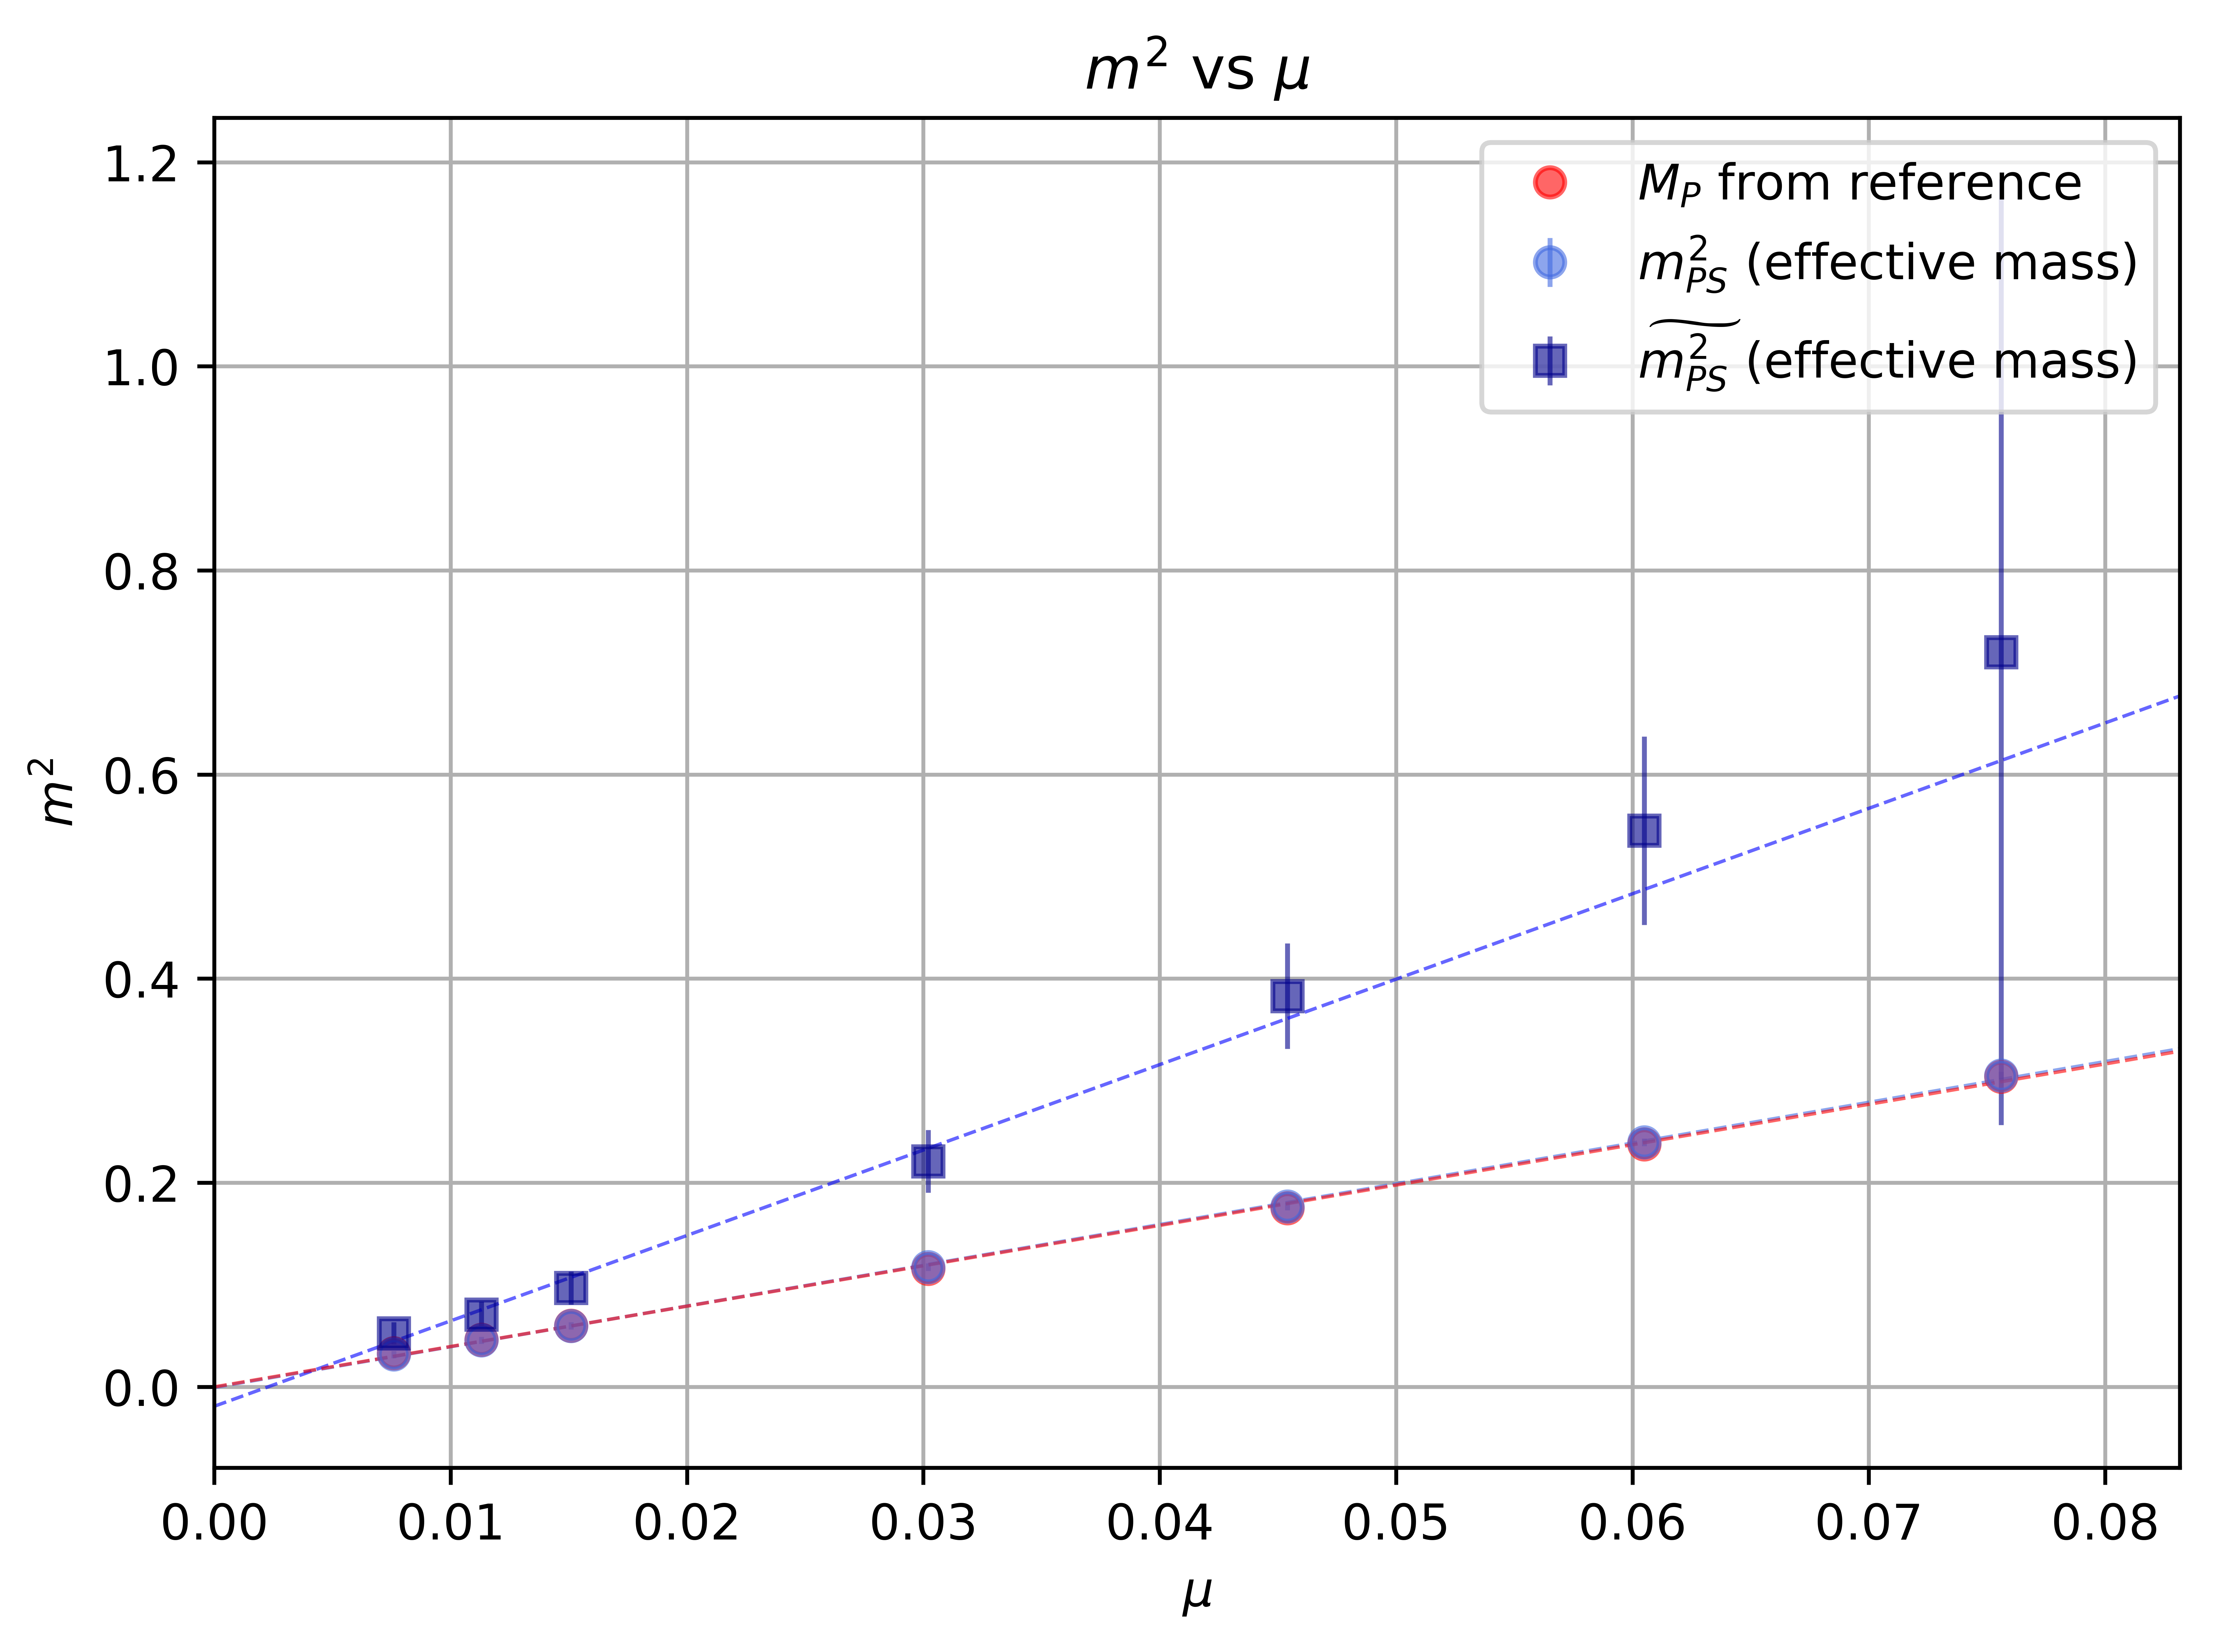

In [28]:
_=plt.figure(dpi=1200)

#_=plt.errorbar(mus,M2_fit,M2_fit_std,marker='o',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (from sinh fit)",color='limegreen',alpha=0.6)
#_=plt.plot(mu_range,M2_fit_linfit,linewidth =0.7,linestyle='dashed',color='limegreen',alpha=0.6)
#_=plt.errorbar(mus,M2t_fit,M2t_fit_std,marker='s',linewidth=0,elinewidth=1.0,label=r"$\widetilde{m_{PS}^2}$ (from sinh fit)",color='darkgreen',alpha=0.6)
#_=plt.plot(mu_range,M2t_fit_linfit,linewidth =0.7,linestyle='dashed',color='darkgreen',alpha=0.6)

_=plt.errorbar(mus,M2_eff,M2_eff_std,marker='o',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (effective mass)",color='royalblue',alpha=0.6)
_=plt.plot(mu_range,M2_eff_linfit,linewidth =0.7,linestyle='dashed',color='royalblue',alpha=0.6)
_=plt.errorbar(mus,M2t_eff,M2t_eff_std,marker='s',linewidth=0,elinewidth=1.0,label=r"$\widetilde{m_{PS}^2}$ (effective mass)",color='darkblue',alpha=0.6)
_=plt.plot(mu_range,M2t_eff_linfit,linewidth =0.7,linestyle='dashed',color='blue',alpha=0.6)



_=plt.plot(mus,sqM_true,marker='o',linewidth=0,label=r"$M_P$ from reference",color='red',alpha=0.6)
_=plt.plot(mu_range,fit_reference,linewidth =0.7,linestyle='dashed',color='red',alpha=0.6)


#_=plt.plot(mus,mass_directfit[::2]**2,'^',label='m direct',linewidth =1,alpha=0.6,color='purple')
#_=plt.plot(mus,mass_directfit[1::2]**2,'v',label='mt direct',linewidth =1,alpha=0.6,color='brown')

#_=plt.errorbar(mus,excM2[::2],excM2_std[::2],marker='^',linewidth=0,elinewidth=1.0,label=r"excM2",color='purple',alpha=0.6)
#_=plt.errorbar(mus,excM2[1::2],excM2_std[1::2],marker='v',linewidth=0,elinewidth=1.0,label=r"excM2_t",color='magenta',alpha=0.6)

_=plt.xlim((0,np.max(mu1)*1.1))

_=plt.xlabel(r"$\mu$")


_=plt.legend()


_=plt.grid()

    
_=plt.title(r"$m^2$ vs $\mu$")
_=plt.ylabel(r"$m^2$")
_=plt.tight_layout()
#plt.savefig('mass_scaling_all_(eoflg0).png')

In [29]:
print("\nM2 eff")
chi2(sqM_true,M2_eff,M2_eff_std) 

print("\nM2t eff")
chi2(sqM_true,M2t_eff,M2t_eff_std) 

print("\nM2 fit")
chi2(sqM_true,M2_fit,M2_fit_std) 

print("\nM2t fit")
chi2(sqM_true,M2t_fit,M2t_fit_std)

print("\nM2 fit vs eff")
chi2(M2_fit,M2_eff,M2_eff_std) 

print("\nM2t fit vs eff")
chi2(M2t_fit,M2t_eff,M2t_eff_std)

#chi2(sqM_true,excM2[::2],excM2_std[::2])
#chi2(sqM_true,excM2[1::2],excM2_std[1::2])


M2 eff


np.float64(0.13978369602951274)


M2t eff


np.float64(7.414907959784082)


M2 fit


np.float64(65.55131860351005)


M2t fit


np.float64(576.7946709912272)


M2 fit vs eff


np.float64(17.184952909358795)


M2t fit vs eff


np.float64(9.357520848204441)

# Fit Check

## Correlators from Jackknife

In [30]:
delta = 1 #binning of the jackknife procedure (we delete delta conf for each replicate

corr_navg_resamp = np.asarray( [np.delete(corr_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0) for iconf in range(0,nconf,delta)] )

nresamples = int(nconf/delta)


if verbose:
    print("(nresamples,nconf-delta,ncorr,tvals)")
    print(np.shape(corr_navg_resamp))

(nresamples,nconf-delta,ncorr,tvals)
(100, 99, 14, 32)


In [31]:
#first we take the correlator averaged over the gauge configurations (for each subsample)
corr_navg_resamp_gavg = corr_navg_resamp.mean(axis=1)

#we then estimate the mass also on the whole dataset
corr_navg_gavg = corr_navg.mean(axis=0)

if verbose:
    print("(nresamples,ncorr,tvals)")
    print(np.shape(corr_navg_resamp_gavg))
    print("(ncorr,tvals)")
    print(np.shape(corr_navg_gavg))

(nresamples,ncorr,tvals)
(100, 14, 32)
(ncorr,tvals)
(14, 32)


In [32]:
okss = np.mean(corr_navg_resamp_gavg,axis=0)

okss.shape

corr_navg_resamp_gavg[:,0].shape

(14, 32)

(100, 32)

In [33]:
#the estimate is the mean of the replicates
corr_estimate = np.mean(corr_navg_resamp_gavg,axis=0) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
corr_bias = (nresamples-1) * (corr_estimate-corr_navg_gavg)
#the std is given by the following formula (variance of replicates times n-1)
corr_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (corr_navg_resamp_gavg[:,icorr] - corr_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
corr_estimate_biascorr = corr_estimate-corr_bias

if verbose:
    print("(ncorr,tvals)")
    print(np.shape(corr_estimate_biascorr))
    print(np.shape(corr_std))

(ncorr,tvals)
(14, 32)
(14, 32)


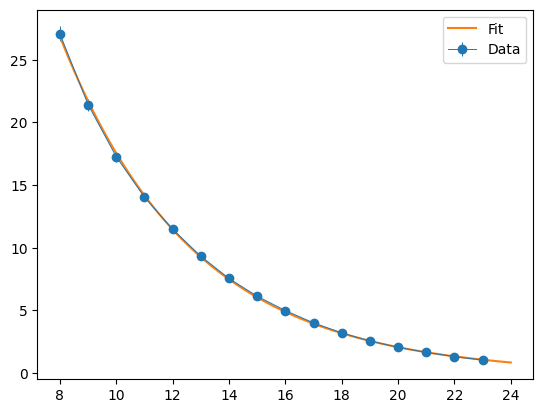

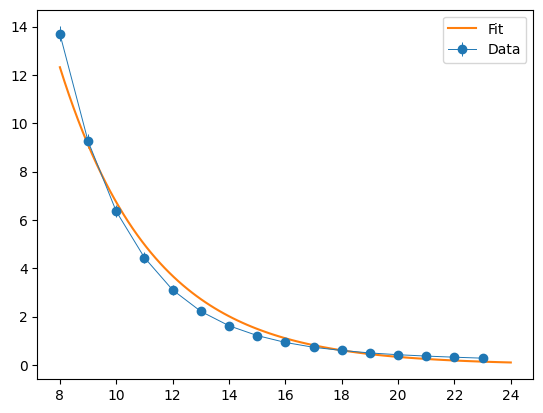

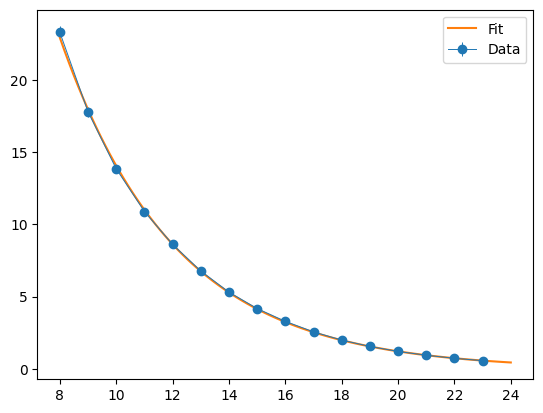

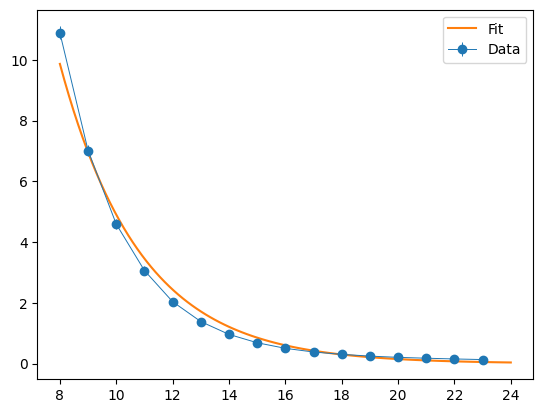

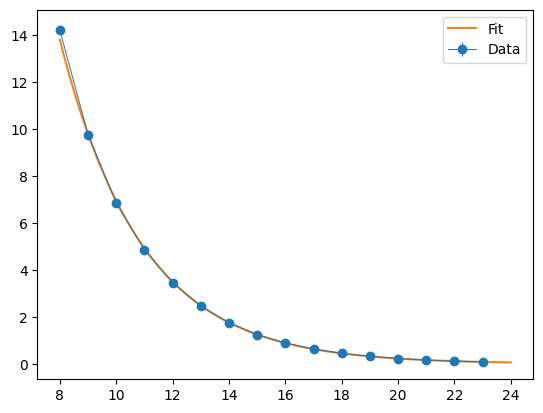

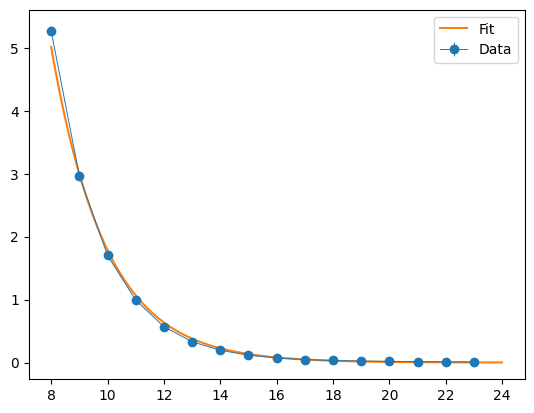

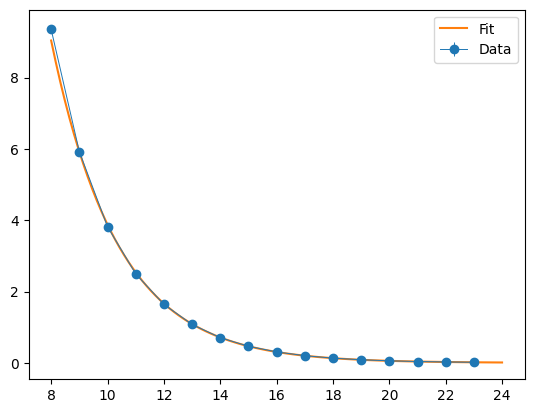

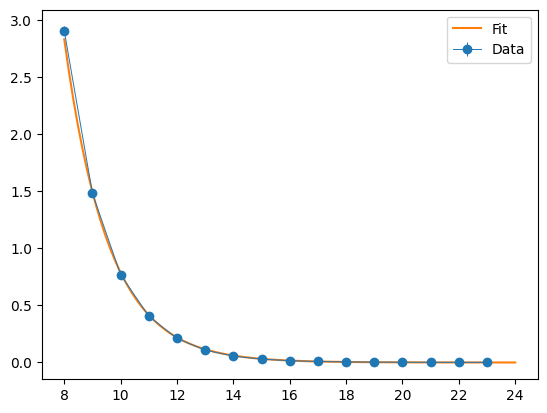

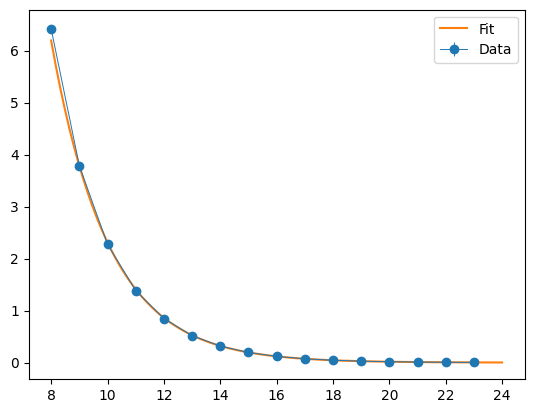

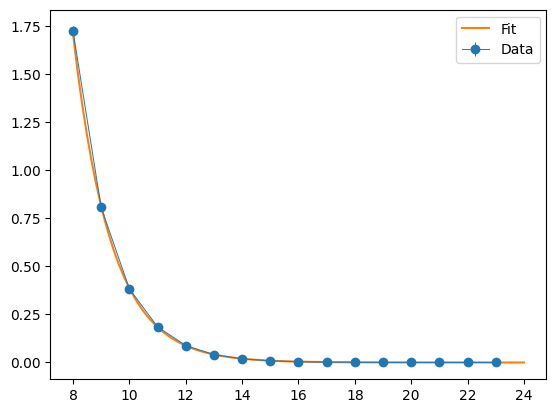

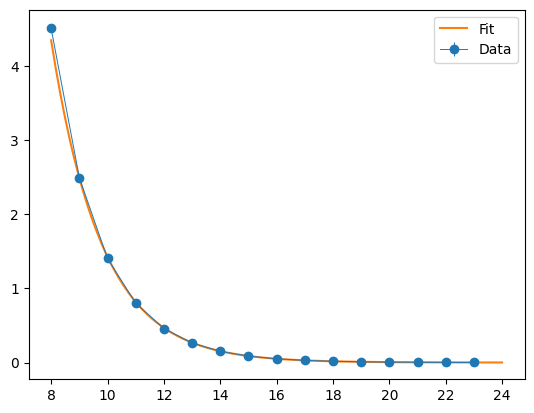

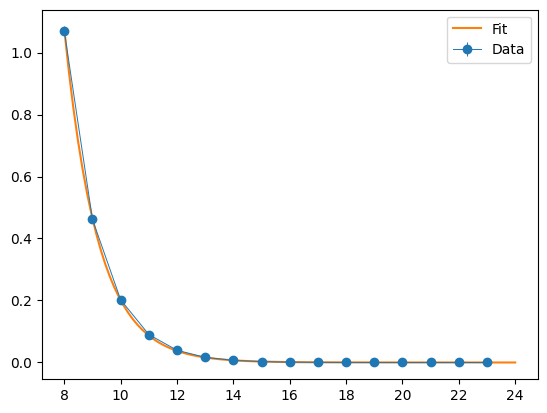

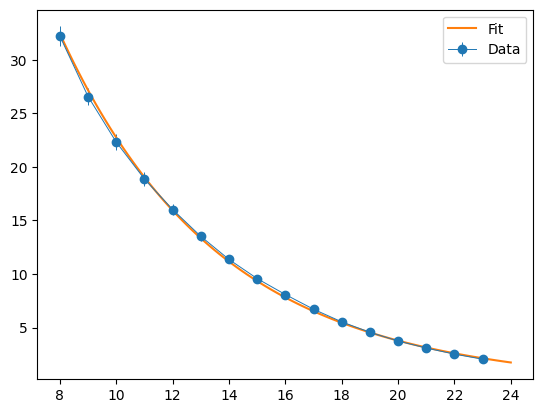

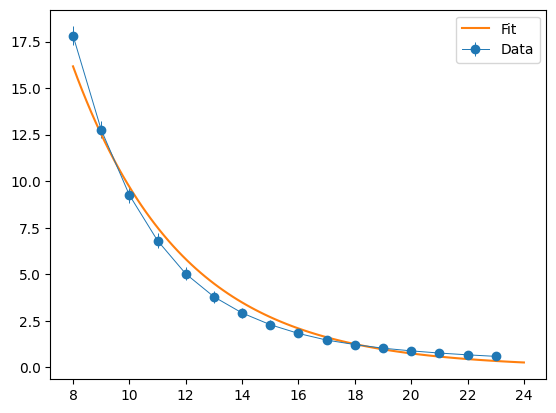

In [34]:
#fit on correlators
cut=8
times = np.arange(tvals)
fit_times=times[cut:-cut]
npoints=100
linspace_times = np.linspace(cut,tvals-cut,npoints)



mass_directfit = np.empty(shape=(ncorr),dtype=float)
amp_directfit = np.empty(shape=(ncorr),dtype=float)

corr_directfit = np.empty(shape=(ncorr,npoints),dtype=float)


chi2_directfit = np.empty(shape=(ncorr),dtype=float)

#loop over correlators
for icorr in range(ncorr):


    guess_mass=true_masses[int(icorr/2)]
    guess_amp=corr_navg_gavg[icorr,int(tvals/2)].real * 2 * np.exp(-tvals/2 * guess_mass)
    guess=[guess_amp,guess_mass]
    
    fit_data=corr_estimate_biascorr[icorr,cut:-cut]
    fit_std=corr_std[icorr,cut:-cut]
    
    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, sigma=fit_std, p0=guess)
    perr_x = np.sqrt(np.diag(pcov_x))
    mass_directfit[icorr] = popt_x[1]
    amp_directfit[icorr] = popt_x[0]
    corr_directfit[icorr] = fit_sinh_x(linspace_times,*popt_x)

    fit_result = fit_sinh_x(fit_times,*popt_x)

    chi2_directfit[icorr] = chi2(fit_result,fit_data,fit_std)


    _=plt.figure()
    _=plt.errorbar(times[cut:-cut],fit_data,corr_std[icorr,cut:-cut],marker='o',linewidth=0.7,label='Data')
    _=plt.plot(linspace_times,corr_directfit[icorr],label='Fit')
    #_=plt.xlim(cut,tvals-cut)
    #_=plt.ylim(np.min(corr_from_data[cut:-cut])*0.9, np.max(corr_from_data[cut:-cut])*1.1 )
    _=plt.legend()

In [35]:
print("\nM2 dirfit chi2")
chi2_directfit[::2]

print("\nM2t dirfit chi2")
chi2_directfit[1::2]


M2 dirfit chi2


array([0.20383895, 0.17298667, 0.6381316 , 1.68822436, 3.12627601,
       4.79691997, 0.36304392])


M2t dirfit chi2


array([ 8.47655937, 12.10820387, 14.72260221,  8.92579495,  3.98498465,
        1.88959639,  4.24260777])

In [36]:
mass_directfit

array([0.21291645, 0.30208694, 0.24433895, 0.34965568, 0.34348865,
       0.51571568, 0.42319469, 0.63966056, 0.49296777, 0.74316949,
       0.55712175, 0.83914781, 0.17739217, 0.25566468])

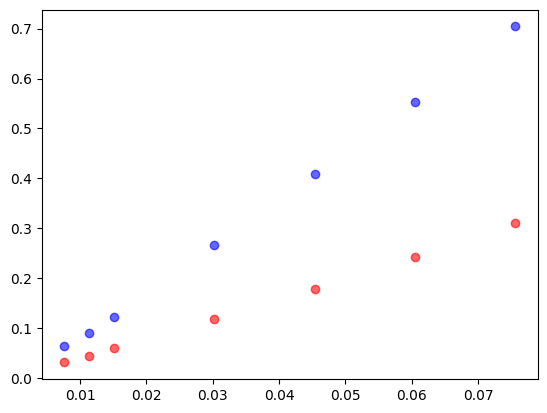

In [37]:
m_dirfit = mass_directfit[::2]
mt_dirfit = mass_directfit[1::2]

_=plt.plot(mus,m_dirfit**2,marker='o',linewidth=0,label=r"m dirfit",color='red',alpha=0.6)
_=plt.plot(mus,mt_dirfit**2,marker='o',linewidth=0,label=r"mt dirfit",color='blue',alpha=0.6)

In [38]:
'''
cut=8

#loop over correlators
for icorr in range(ncorr):






    #direct fit
    #mass from fit for each of the replicate
    guess_mass=true_masses[int(icorr/2)]
    cut=8
    fit_times=times[cut:-cut]
    guess_amp=corr_navg_gavg[icorr,int(tvals/2)].real * 2 * np.exp(-tvals/2 * guess_mass)
    guess=[guess_amp,guess_mass]
    fit_data=corr_navg_gavg[icorr,cut:-cut].real
    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess)
    perr_x = np.sqrt(np.diag(pcov_x))
    fit_mass_array_jacktotal[icorr] = popt_x[1]
    fit_amp_array_jacktotal[icorr] = popt_x[0]
    



    

    corr_from_data = corr_navg_gavg[icorr]

    corr_from_fit = fit_sinh_x(linspace_times,amp_fit[icorr],M_fit[icorr])

    _=plt.figure()
    _=plt.plot(times,corr_from_data,'-o',linewidth=0.7,label='Data')
    _=plt.plot(linspace_times,corr_from_fit,label='Fit')
    _=plt.xlim(cut,tvals-cut)
    _=plt.ylim(np.min(corr_from_data[cut:-cut])*0.9, np.max(corr_from_data[cut:-cut])*1.1 )
    _=plt.legend()
    '''

"\ncut=8\n\n#loop over correlators\nfor icorr in range(ncorr):\n\n\n\n\n\n\n    #direct fit\n    #mass from fit for each of the replicate\n    guess_mass=true_masses[int(icorr/2)]\n    cut=8\n    fit_times=times[cut:-cut]\n    guess_amp=corr_navg_gavg[icorr,int(tvals/2)].real * 2 * np.exp(-tvals/2 * guess_mass)\n    guess=[guess_amp,guess_mass]\n    fit_data=corr_navg_gavg[icorr,cut:-cut].real\n    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess)\n    perr_x = np.sqrt(np.diag(pcov_x))\n    fit_mass_array_jacktotal[icorr] = popt_x[1]\n    fit_amp_array_jacktotal[icorr] = popt_x[0]\n    \n\n\n\n    \n\n    corr_from_data = corr_navg_gavg[icorr]\n\n    corr_from_fit = fit_sinh_x(linspace_times,amp_fit[icorr],M_fit[icorr])\n\n    _=plt.figure()\n    _=plt.plot(times,corr_from_data,'-o',linewidth=0.7,label='Data')\n    _=plt.plot(linspace_times,corr_from_fit,label='Fit')\n    _=plt.xlim(cut,tvals-cut)\n    _=plt.ylim(np.min(corr_from_data[cut:-cut])*0.9, np.max(corr_from

# Extra check

In [39]:
M_eff
M_eff_std

array([0.21325305, 0.26612701, 0.24424257, 0.31107426, 0.34252385,
       0.47008312, 0.42034772, 0.61877808, 0.48946308, 0.73821413,
       0.55229354, 0.84848122, 0.17795869, 0.22869628])

array([0.0083196 , 0.02378291, 0.00740633, 0.02618566, 0.005474  ,
       0.03273971, 0.00454241, 0.04172763, 0.00387882, 0.06253854,
       0.00348073, 0.27306347, 0.00997597, 0.02382825])

In [40]:
def eff_mass_func(t,mps,E1,c1,c2):
    return mps+c1*np.exp(-E1*t)+c2*np.exp(-2*mps*(tvals-1-t))
#def eff_mass_func(t,mps,E1,c1):
 #   return mps+c1*np.exp(-E1*t)#+c2*np.exp(-2*mps*(tvals-1-t))

In [41]:
cut=4
times = np.arange(tvals)
fit_times_m=times[cut:-cut-1]+0.5

extra_check_masses = np.empty(shape=(ncorr),dtype=float)
extra_check_masses_std = np.empty(shape=(ncorr),dtype=float)

for icorr in range(ncorr):

    meff = eff_estimate_biascorr[icorr,cut:-cut]
    meff_std = eff_std[icorr,cut:-cut]
    
    guess_par = [ true_masses[int(icorr/2)] , true_masses[int(icorr/2)], true_masses[int(icorr/2)], true_masses[int(icorr/2)] ]
    #guess_par = [ true_masses[int(icorr/2)] , true_masses[int(icorr/2)], 0.0 ]
    popt,pcov = curve_fit(eff_mass_func, fit_times_m, meff, sigma= meff_std, p0=guess_par,maxfev=5000)

    print(popt)
    #print(pcov)
    extra_check_masses[icorr] = popt[0]
    extra_check_masses_std[icorr] = np.sqrt(np.diag(pcov))[0]

excM2 = extra_check_masses**2
excM2_std = 2*extra_check_masses*extra_check_masses_std

[ 0.21330401  0.68612653  6.49535584 -0.12113843]
[0.24717939 0.26279829 1.16304272 0.05404477]
[ 0.24461302  0.6508902   5.41338312 -0.3989064 ]
[ 0.25312547  0.20911979  0.99243085 -6.85953892]
[ 0.34137259  0.57270903  3.63013819 -1.52634379]
[ 0.20621058  0.11199745  0.92171858 -2.86419685]
[ 0.41915161  0.53545595  3.00793979 -2.60663974]
[ 0.23085689  0.09386005  0.96884216 -4.65699749]
[ 0.48761458  0.51449865  2.70254874 -3.7017763 ]
[ 7.13514145e-01  4.66802684e-01  2.12233285e+00 -6.43867859e+02]
[ 0.55080507  0.5005953   2.51298031 -4.88115365]
[0.5512 0.5512 0.5512 0.5512]
[0.17645773 0.73384607 8.32254286 0.12597318]
[ 0.19184302  0.26073069  1.17898842 -3.09532696]


/home/tag-e/università/Magistrale/tesi/codice/myCode/python_analysis/my_env_2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:975: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/tmp/ipykernel_25746/2614299248.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(eff_mass_func, fit_times_m, meff, sigma= meff_std, p0=guess_par,maxfev=5000)


In [42]:
excM2

array([0.0454986 , 0.06109765, 0.05983553, 0.0640725 , 0.11653525,
       0.0425228 , 0.17568808, 0.0532949 , 0.23776798, 0.50910244,
       0.30338623, 0.30382144, 0.03113733, 0.03680375])

In [43]:
mu_range = np.linspace(0,np.max(mu1)*1.1,100)

excM2_ = excM2[::2]
excM2_std_ = excM2_std[::2]
excM2_t = excM2[1::2]
excM2_std_t = excM2_std[1::2]

guess_par = [ ( excM2_[-1]+excM2_[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, excM2_, sigma= excM2_std_, p0=guess_par)
excM2_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)

guess_par = [ ( excM2_t[-1]+excM2_t[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, excM2_t, sigma= excM2_std_t, p0=guess_par)
excM2t_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)

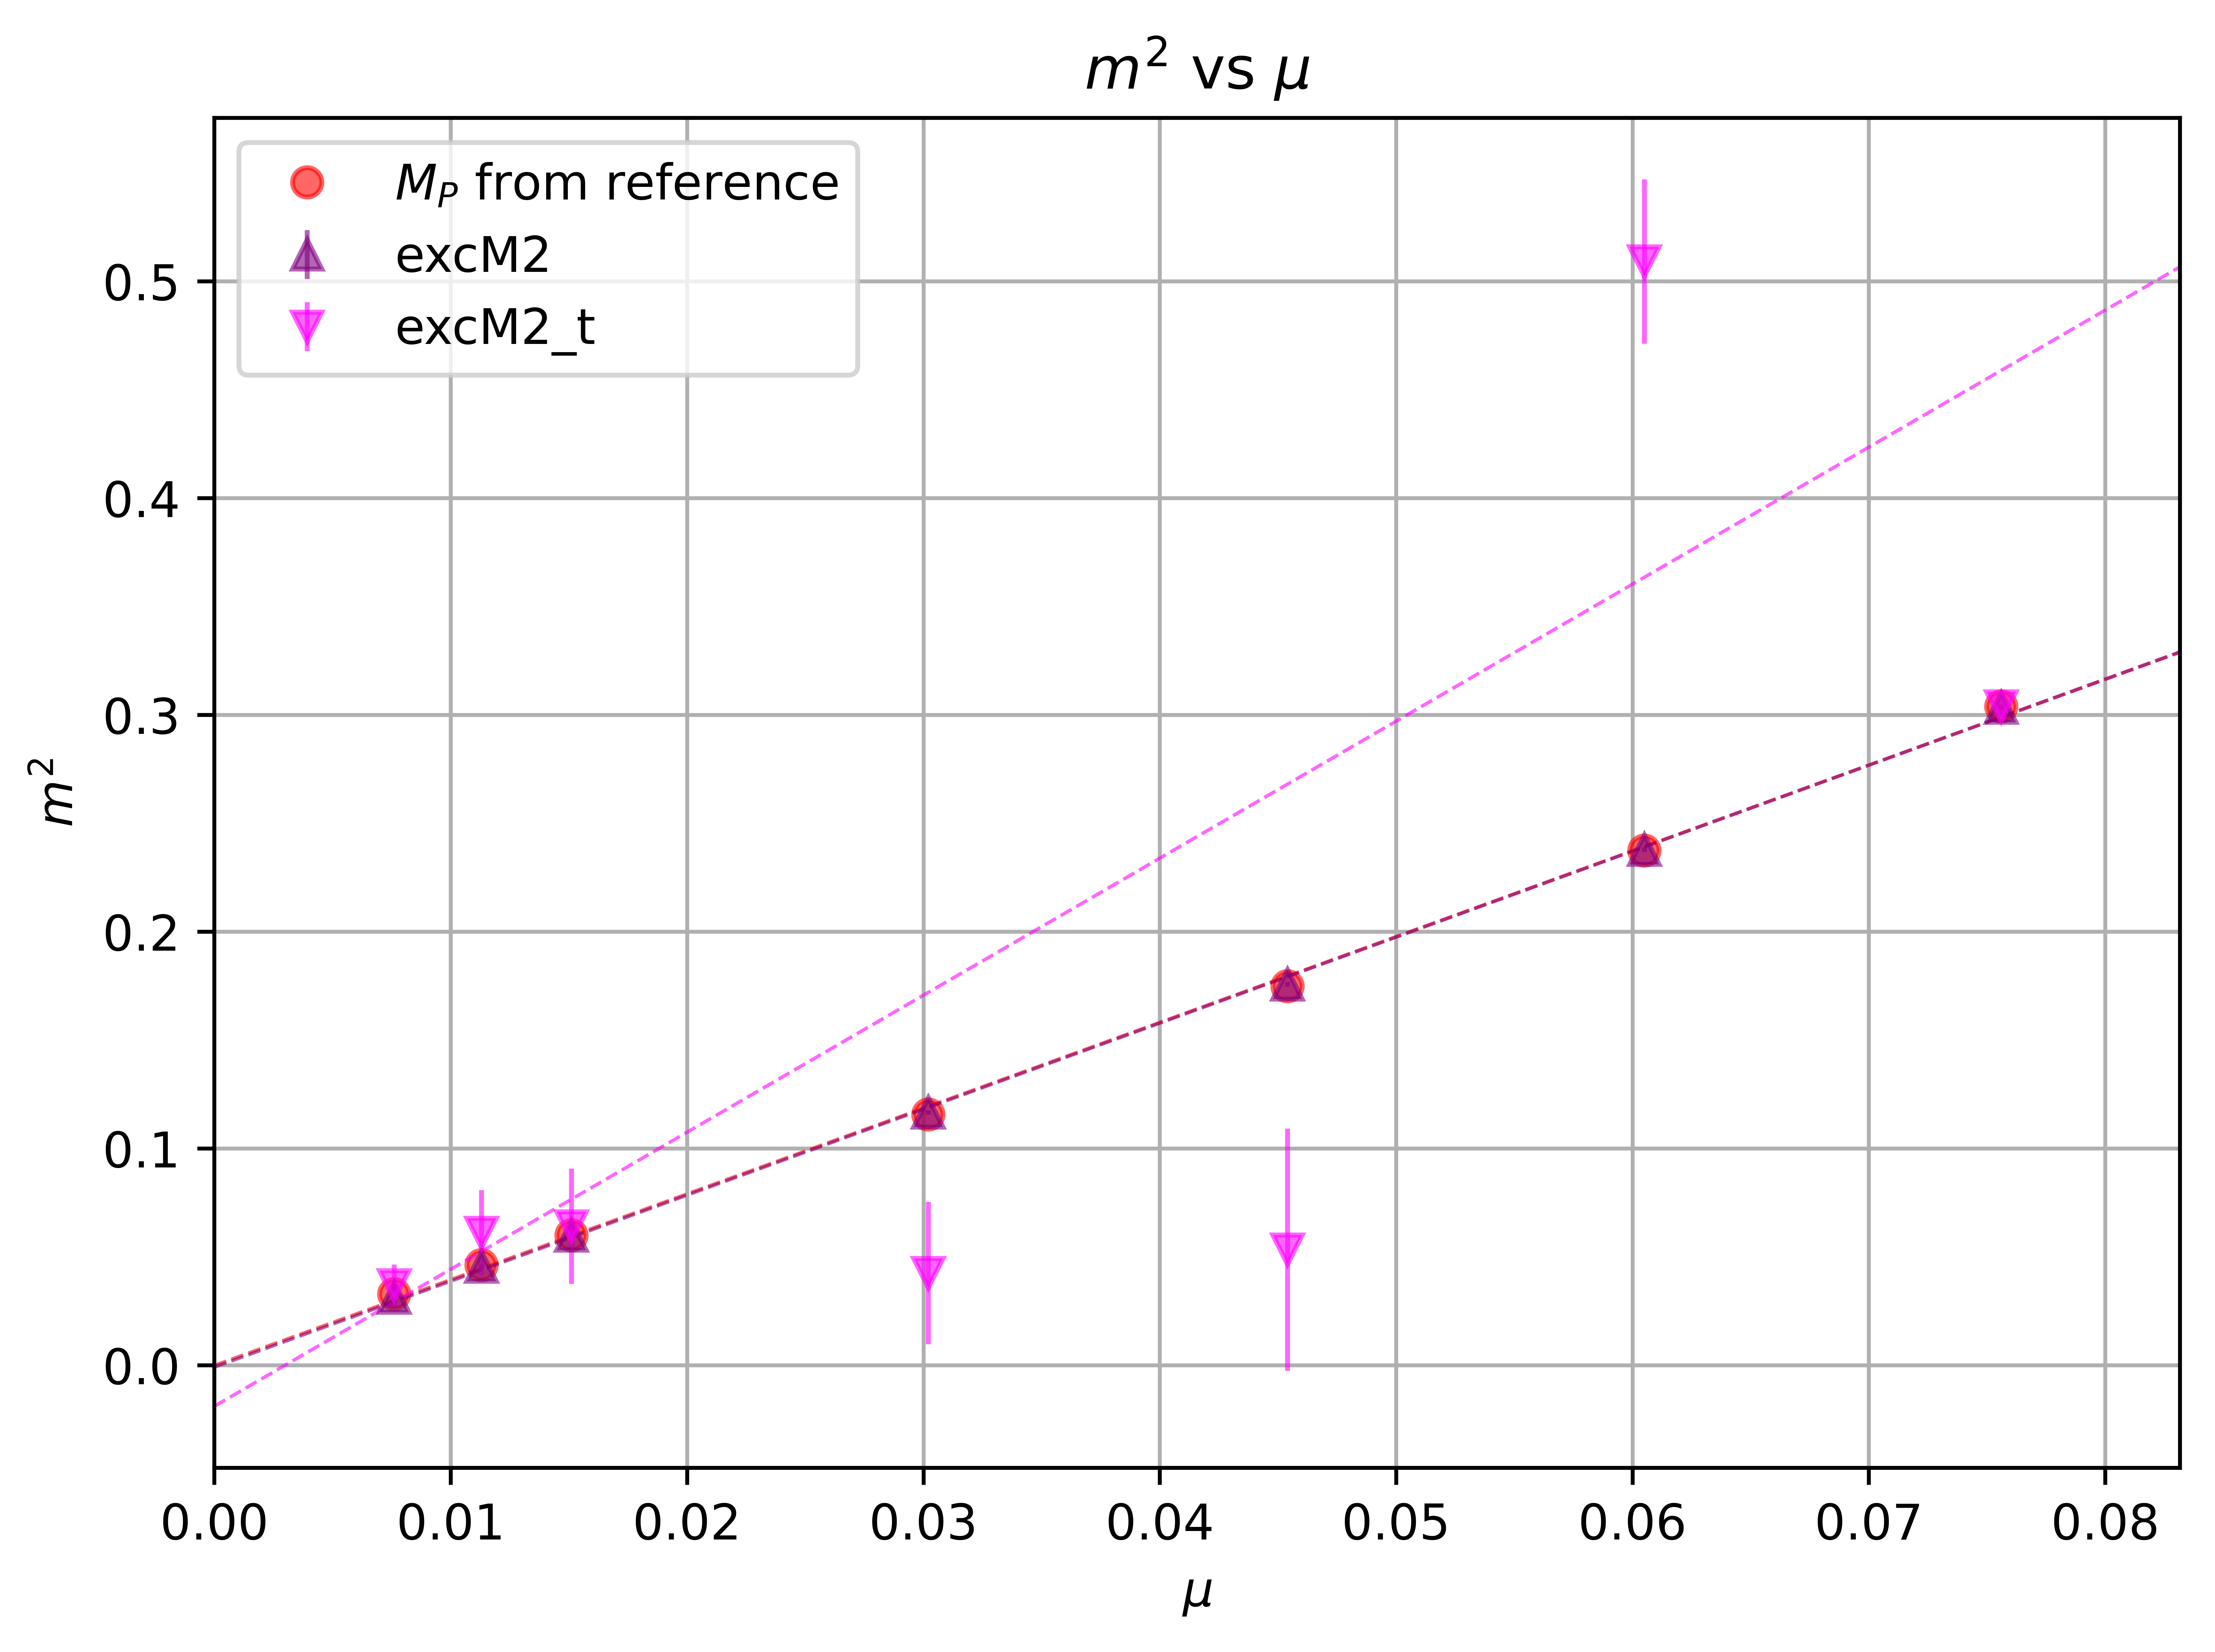

In [44]:
_=plt.figure(dpi=1200)

#_=plt.errorbar(mus,M2_fit,M2_fit_std,marker='o',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (from sinh fit)",color='limegreen',alpha=0.6)
#_=plt.plot(mu_range,M2_fit_linfit,linewidth =0.7,linestyle='dashed',color='limegreen',alpha=0.6)
#_=plt.errorbar(mus,M2t_fit,M2t_fit_std,marker='s',linewidth=0,elinewidth=1.0,label=r"$\widetilde{m_{PS}^2}$ (from sinh fit)",color='darkgreen',alpha=0.6)
#_=plt.plot(mu_range,M2t_fit_linfit,linewidth =0.7,linestyle='dashed',color='darkgreen',alpha=0.6)

#_=plt.errorbar(mus,M2_eff,M2_eff_std,marker='o',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (effective mass)",color='royalblue',alpha=0.6)
#_=plt.plot(mu_range,M2_eff_linfit,linewidth =0.7,linestyle='dashed',color='royalblue',alpha=0.6)
#_=plt.errorbar(mus,M2t_eff,M2t_eff_std,marker='s',linewidth=0,elinewidth=1.0,label=r"$\widetilde{m_{PS}^2}$ (effective mass)",color='darkblue',alpha=0.6)
#_=plt.plot(mu_range,M2t_eff_linfit,linewidth =0.7,linestyle='dashed',color='blue',alpha=0.6)



_=plt.plot(mus,sqM_true,marker='o',linewidth=0,label=r"$M_P$ from reference",color='red',alpha=0.6)
_=plt.plot(mu_range,fit_reference,linewidth =0.7,linestyle='dashed',color='red',alpha=0.6)


#_=plt.plot(mus,mass_directfit[::2]**2,'^',label='m direct',linewidth =1,alpha=0.6,color='purple')
#_=plt.plot(mus,mass_directfit[1::2]**2,'v',label='mt direct',linewidth =1,alpha=0.6,color='brown')

_=plt.errorbar(mus,excM2[::2],excM2_std[::2],marker='^',linewidth=0,elinewidth=1.0,label=r"excM2",color='purple',alpha=0.6)
_=plt.plot(mu_range,excM2_fit_linfit,linewidth =0.7,linestyle='dashed',color='purple',alpha=0.6)
_=plt.errorbar(mus,excM2[1::2],excM2_std[1::2],marker='v',linewidth=0,elinewidth=1.0,label=r"excM2_t",color='magenta',alpha=0.6)
_=plt.plot(mu_range,excM2t_fit_linfit,linewidth =0.7,linestyle='dashed',color='magenta',alpha=0.6)

_=plt.xlim((0,np.max(mu1)*1.1))

_=plt.xlabel(r"$\mu$")


_=plt.legend()


_=plt.grid()

    
_=plt.title(r"$m^2$ vs $\mu$")
_=plt.ylabel(r"$m^2$")
_=plt.tight_layout()
#plt.savefig('mass_scaling_all_(eoflg0).png')

In [45]:
chi2(sqM_true,M2_eff,M2_eff_std)
chi2(sqM_true,M2t_eff,M2t_eff_std)
chi2(sqM_true,M2_fit,M2_fit_std)
chi2(sqM_true,M2t_fit,M2t_fit_std)

chi2(M2_fit,M2_eff,M2_eff_std)
chi2(M2t_fit,M2t_eff,M2t_eff_std)

chi2(sqM_true,excM2[::2],excM2_std[::2])
chi2(sqM_true,excM2[1::2],excM2_std[1::2])

np.float64(0.13978369602951274)

np.float64(7.414907959784082)

np.float64(65.55131860351005)

np.float64(576.7946709912272)

np.float64(17.184952909358795)

np.float64(9.357520848204441)

np.float64(0.5900136003848939)

np.float64(8.820276082596745)